In [1]:
# Импортируем основные модули pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Импортируем модули, связанные с компьютерным зрением
from torchvision import datasets
from torchvision.transforms import ToTensor

# Импортируем вспомогательные модули
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [2]:
# В данной лабораторной работе вам необходимо обучить две сети с архитектурой,
# которую вам необходимо разработать самостоятельно.
# В этой части предлагается реализовать полносвязную сеть без использования сверточных слоев.
# Поэкспериментируйте с использованием слоев пакетной нормализации и дропаута.
# Сравните точность на тестовой выборке с аналогичными результатами одногруппников.
class FCNet(nn.Module):

    def __init__(self):
        super().__init__()

        # ВАШ КОД ЗДЕСЬ
        self.fc1 = nn.Linear(3*32*32, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 80)
        self.fc4 = nn.Linear(80, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.bn = nn.BatchNorm1d(500)
        # ===============

    def forward(self, x):
        # ВАШ КОД ЗДЕСЬ
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.bn(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        # ===============


In [3]:
# Задаем количество эпох (проходов по всей обучающей выборке) и размер пакета, можно варьировать
EPOCHS = 20
BATCH_SIZE = 256

# Загружаем данные из набора CIFAR10
train_data = datasets.CIFAR10(root='./data/train', train=True, download=True, transform=ToTensor())
test_data = datasets.CIFAR10(root='./data/test', train=False, download=True, transform=ToTensor())

# DataLoader позволяет разбить выборку на пакеты заданного размера.
# Параметр shuffle отвечает за перемешивание данных в пакете
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Если графический ускоритель поддерживает обучение на нем, будем использовать его,
# иначе обучать на процессоре.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Готовимся к обучению
model = FCNet().to(device)  # создаем модель
optimizer = torch.optim.AdamW(model.parameters())  # оптимизатор, нужно выбрать и настроить
loss_function = nn.CrossEntropyLoss()  # функция потерь, нужно выбрать
loss_history = list()  # список для хранения истории изменения функции стоимости


In [7]:
# Начинаем обучение
for epoch in range(EPOCHS):
    for i, (batch, labels) in enumerate(train_loader):  # разбиваем выборку на пакеты
        # Нужно реализовать один шаг градиентного спуска
        loss = torch.tensor(0, dtype=torch.float32)  # значение функции стоимости на пакете, нужно рассчитать
        # ВАШ КОД ЗДЕСЬ
        optimizer.zero_grad()
        
        outputs = model(batch.cuda())
        loss = loss_function(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        # ===============
        loss_history.append(loss.log().item())  # добавляется логарифм стоимости для большей наглядности
    print(f'Эпоха {epoch + 1} завершилась с функцией стоимости на последнем пакете = {loss.item()}')


Эпоха 1 завершилась с функцией стоимости на последнем пакете = 1.7944204807281494
Эпоха 2 завершилась с функцией стоимости на последнем пакете = 1.536004662513733
Эпоха 3 завершилась с функцией стоимости на последнем пакете = 1.7640702724456787
Эпоха 4 завершилась с функцией стоимости на последнем пакете = 1.5146276950836182
Эпоха 5 завершилась с функцией стоимости на последнем пакете = 1.345325231552124
Эпоха 6 завершилась с функцией стоимости на последнем пакете = 1.4745738506317139
Эпоха 7 завершилась с функцией стоимости на последнем пакете = 1.5188930034637451
Эпоха 8 завершилась с функцией стоимости на последнем пакете = 1.437323808670044
Эпоха 9 завершилась с функцией стоимости на последнем пакете = 1.3509858846664429
Эпоха 10 завершилась с функцией стоимости на последнем пакете = 1.2984721660614014
Эпоха 11 завершилась с функцией стоимости на последнем пакете = 1.3819575309753418
Эпоха 12 завершилась с функцией стоимости на последнем пакете = 1.3010964393615723
Эпоха 13 заверши

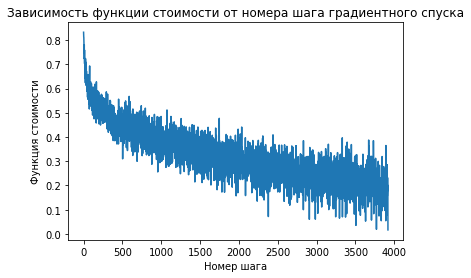

In [8]:
# Выводим график функции стоимости
plt.title('Зависимость функции стоимости от номера шага градиентного спуска')
plt.xlabel('Номер шага')
plt.ylabel('Функция стоимости')
plt.plot(loss_history)
plt.show()

In [10]:
# Отключаем расчет вычислительного графа для экономии времени и памяти: нам не нужно считать градиенты при тестировании модели
with torch.no_grad():
    # Оцениваем качество модели
    train_data_loader = DataLoader(train_data, batch_size=len(train_data))
    train_features, train_targets = next(iter(train_data_loader))

    train_features = train_features.to(device)
    train_model_predictions = torch.argmax(model(train_features), dim=1)
    print('Точность (accuracy) на обучающей выборке:', accuracy_score(train_data.targets, train_model_predictions.cpu()))

    test_data_loader = DataLoader(test_data, batch_size=len(test_data))
    test_features, test_targets = next(iter(test_data_loader))

    test_features = test_features.to(device)
    test_model_predictions = torch.argmax(model(test_features), dim=1)
    print('Точность (accuracy) на тестовой выборке:', accuracy_score(test_data.targets, test_model_predictions.cpu()))


Точность (accuracy) на обучающей выборке: 0.57626
Точность (accuracy) на тестовой выборке: 0.5149
